# 1.) Import an asset price from Yahoo Finance

In [73]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("^IRX", start="1990-01-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [7]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])

In [12]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [37]:
###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

In [38]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

6447/6447 [==============================] - 41s 6ms/step - loss: 0.1453


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [39]:

test_data = scaled_data[training_data_len - input_size:, :]

x_test = [] 
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [40]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

51/51 [==============================] - 0s 3ms/step


In [58]:
train_rmse = np.sqrt(np.mean((train_pred - y_train)**2))
test_rmse = np.sqrt(np.mean((test_pred - y_test)**2))
insample_random_walk = (1 - np.mean(np.abs(y_train[1:] - y_train[:-1])) / np.std(y_train)) 
outsample_random_walk = (1 - np.mean(np.abs(y_test[1:] - y_test[:-1])) / np.std(y_test)) 

In [59]:
print('train_rmse:',train_rmse,' test_rmse:',test_rmse,' insample_random_walk:',insample_random_walk,' outsample_random_walk:',outsample_random_walk)

train_rmse: 0.3931868716814051  test_rmse: 0.3509888168974401  insample_random_walk: 0.6798742222868439  outsample_random_walk: 0.6357408994238931


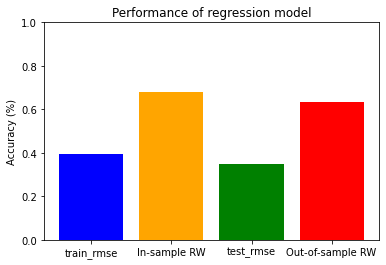

In [64]:
import matplotlib.pyplot as plt

metrics = ['train_rmse', 'In-sample RW', 'test_rmse', 'Out-of-sample RW']
accuracies = [train_rmse, insample_random_walk, test_rmse, outsample_random_walk]
colors = ['blue', 'orange', 'green', 'red']

plt.bar(metrics, accuracies, color=colors)
plt.title('Performance of regression model')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 1])
plt.show()

# 4.) Plot in and out of sample accuracy


```
# import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
```



#5.) Write an observation/conclusion about the graphs from Q4 and Q3

rmse performance of train and test set don't have much difference, so is the random walk test accuracy.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [85]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

In [166]:
def resample(input_size):
    x_train = []
    y_train = []

    for i in range(input_size, len(train_data)):
       x_train.append(train_data[i-input_size:i, 0])
       y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train

model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [169]:
#param_grid = {'input_size': [5, 10, 20]}

# Wrap the Keras model in a scikit-learn compatible estimator
#x_train, y_train= resample(input_size)
#model = KerasRegressor(build_fn=create_model, verbose=0)

# Perform the grid search over the hyperparameters
#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
#grid_result = grid.fit(x_train, y_train)

# Print the results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [167]:
input_size = [5,10,20]
for i in input_size:
  x_train, y_train= resample(i)
  model.fit(x_train, y_train, batch_size=1, epochs=1)
  train_pred = model.predict(x_train)
  test_pred = model.predict(x_test)
  print(i,':   ',np.sqrt(np.mean((train_pred - y_train)**2)))
  print(i,':   ',np.sqrt(np.mean((test_pred - y_test)**2)))

51/51 [==============================] - 0s 5ms/step
5 :    0.39236203798973607
5 :    0.33499515633912885
51/51 [==============================] - 0s 3ms/step
10 :    0.4021585976652506
10 :    0.33820077473130766
51/51 [==============================] - 0s 3ms/step
20 :    0.38986726817483996
20 :    0.33675201455277404


I tried many times but I couldn't use GridSearchCV to get what I want, so I have to use for loop. For in-sample MSE, use 15 days of data perform the best, while for out-of-sample MSE, use 5 days of data is good enough.